### Price Sensitivity Analysis and Optimization

___

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import torch
import torch.nn as nn
import torch.optim as optim


training_data = pd.read_csv("/kaggle/input/e-commerce-synthetic-dataset/ecommerce_synthetic_data.csv")
training_data.head()

/kaggle/input/e-commerce-synthetic-dataset/ecommerce_synthetic_data.csv


,ordered,past_spending,price,quantity,membership_flag,goods_type_clothing,goods_type_eletronics,goods_type_food,goods_type_furniture,goods_type_kichenware,goods_type_medicine,brand_tier_cheap,brand_tier_highend,brand_tier_popular
0,0,1023.73,63.323601,1,0,1,0,0,0,0,0,1,0,0
1,0,0.00,489.880202,2,0,0,1,0,0,0,0,0,1,0
2,0,1873.31,179.044065,5,0,1,0,0,0,0,0,0,1,0
3,0,592.82,372.990431,1,0,0,1,0,0,0,0,0,0,1
4,0,796.50,401.885614,1,1,0,0,0,1,0,0,0,0,1


___
#### Preprocess Training Data

In [2]:
# Good's type column from one-hot encoded columns for stratification
product_info = pd.concat(
    [
        pd.from_dummies(training_data[[x for x in training_data.columns if "goods" in x]], sep="_"),
        pd.from_dummies(training_data[[x for x in training_data.columns if "brand" in x]], sep="_"),
    ],
    axis=1,
)

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    training_data[[x for x in training_data.columns if x != "ordered"]], 
    training_data["ordered"], 
    test_size=0.5, 
    random_state=2024, 
    stratify=product_info,
)

# Features in training set
features_train = X_train[[x for x in X_train.columns if x != "price"]]
features_scaler = StandardScaler().fit(features_train[["past_spending", "quantity"]])
features_train[["past_spending", "quantity"]] = features_scaler.transform(
    features_train[["past_spending", "quantity"]]
)

# Features in testing set
features_test = X_test[[x for x in X_test.columns if x != "price"]]
features_test[["past_spending", "quantity"]] = features_scaler.transform(
    features_test[["past_spending", "quantity"]]
)

In [3]:
price_product_info = pd.concat([training_data["price"], product_info], axis=1)
price_train = price_product_info[price_product_info.index.isin(X_train.index)]
price_test = price_product_info[price_product_info.index.isin(X_test.index)]

price_scalers = {}
for x in price_product_info["goods"].unique():
    price_train_scale = price_train.loc[price_train["goods"] == x, "price"].values.reshape(-1,1)
    price_test_scale = price_test.loc[price_test["goods"] == x, "price"].values.reshape(-1,1)
    # Scale with training prices
    price_scaler = MinMaxScaler().fit(price_train_scale)
    price_train.loc[price_train["goods"] == x, "price"] = price_scaler.transform(price_train_scale)
    price_test.loc[price_test["goods"] == x, "price"] = price_scaler.transform(price_test_scale)
    price_scalers[x] = price_scaler

print("Scaled prices evenly distributed across good's type")
price_test.groupby("goods")["price"].describe().round(3)

Scaled prices evenly distributed across good's type


,count,mean,std,min,25%,50%,75%,max
goods,,,,,,,,
type_clothing,1675.0,0.241,0.176,0.001,0.103,0.195,0.344,0.930
type_eletronics,1652.0,0.343,0.204,0.029,0.167,0.303,0.485,1.070
type_food,1628.0,0.294,0.214,-0.000,0.128,0.235,0.420,0.994
type_furniture,1659.0,0.323,0.198,-0.003,0.162,0.275,0.451,0.951
type_kichenware,1732.0,0.304,0.212,0.001,0.142,0.240,0.445,0.931
type_medicine,1654.0,0.283,0.182,-0.006,0.138,0.241,0.392,1.034


In [4]:
# Convert dataframe and numpy array into tensors
features_train_tensor = torch.tensor(features_train.values, dtype=torch.float32)
price_train_tensor = torch.tensor(price_train["price"].values.reshape(-1,1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1,1), dtype=torch.float32)

features_test_tensor = torch.tensor(features_test.values, dtype=torch.float32)
price_test_tensor = torch.tensor(price_test["price"].values.reshape(-1,1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1,1), dtype=torch.float32)

___
#### Train Win Rate Model with Price-Response Function

In [5]:
class MaxWinRateParam(nn.Module):
    def __init__(self):
        super(MaxWinRateParam, self).__init__()
        self.hidden_layer = nn.Linear(12, 5)
        self.output_layer = nn.Linear(5, 1)
        self.sigmoid_activation = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        x = self.sigmoid_activation(x)
        return x


class BiasParam(nn.Module):
    def __init__(self):
        super(BiasParam, self).__init__()
        self.hidden_layer = nn.Linear(12, 5)
        self.relu_activation = nn.ReLU()
        self.output_layer = nn.Linear(5, 1)
        self.elu_activation = nn.ELU()

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.relu_activation(x)
        x = self.output_layer(x)
        x = self.elu_activation(x)
        return x


class SensitivityParam(nn.Module):
    def __init__(self):
        super(SensitivityParam, self).__init__()
        self.hidden_layer = nn.Linear(12, 5)
        self.relu_activation = nn.ReLU()
        self.output_layer = nn.Linear(5, 1)

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.relu_activation(x)
        x = self.output_layer(x)
        x = self.relu_activation(x)
        return torch.exp(x) - 1


class WinRateNetwork(nn.Module):
    def __init__(self):
        super(WinRateNetwork, self).__init__()
        self.max_win_rate = MaxWinRateParam()
        self.bias = BiasParam()
        self.sensitivity = SensitivityParam()

    def forward(self, features, price, train=False):
        mul_term = torch.mul(self.sensitivity(features), price)
        add_term = torch.add(self.bias(features), mul_term)
        win_rate = self.max_win_rate(features) / (1 + torch.exp(add_term))
        if train:
            return win_rate
        return (
            win_rate,
            self.max_win_rate(features),
            self.bias(features),
            self.sensitivity(features),
        )

In [6]:
# Training parameters
torch.manual_seed(1234)
n_epochs = 100
batch_size = 256
batches_per_epoch = len(features_train_tensor) // batch_size

# Model settings
model = WinRateNetwork()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(n_epochs):
    if epoch % 10 == 0:
        print(f"Epoch: {epoch + 1}")
    for i in range(batches_per_epoch):
        start = i * batch_size
        X_batch = features_train_tensor[start:(start + batch_size)]
        price_batch = price_train_tensor[start:(start + batch_size)]
        y_batch = y_train_tensor[start:(start + batch_size)]
        # Forward pass
        y_pred = model(X_batch, price_batch, train=True)
        loss = criterion(y_pred, y_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # Update weights

Epoch: 1
Epoch: 11
Epoch: 21
Epoch: 31
Epoch: 41
Epoch: 51
Epoch: 61
Epoch: 71
Epoch: 81
Epoch: 91


___
#### Evaluate the Model

Prediction accuracy at threshold 0.5: 86.30%


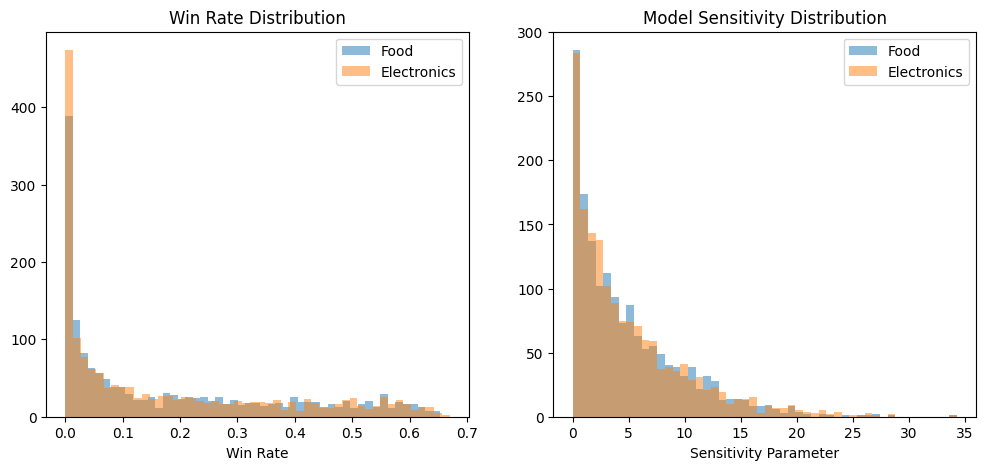

In [7]:
win_rate_test, max_win_rate_test, bias_test, sensitivity_test = model(features_test_tensor, price_test_tensor)

pred_win_rate_test = win_rate_test.detach().numpy()
pred_max_win_rate_test = max_win_rate_test.detach().numpy()
pred_bias_test = bias_test.detach().numpy()
pred_sensitivity_test = sensitivity_test.detach().numpy()

pred_goods_test = pd.concat(
    [
        product_info[product_info.index.isin(X_test.index)].reset_index(), 
        pd.Series(pred_win_rate_test.ravel(), name="predicted_win_rate"),
        pd.Series(pred_sensitivity_test.ravel(), name="predicted_sensitivity"),
    ], 
    axis=1,
)

conversion_accuracy = ((pred_win_rate_test > 0.5).astype(int).ravel() == y_test.values).mean()
print(f"Prediction accuracy at threshold 0.5: {conversion_accuracy:.2%}")

fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].hist(
    pred_goods_test.loc[pred_goods_test["goods"] == "type_food", "predicted_win_rate"], 
    bins=50, alpha=0.5, label="Food"
)
ax[0].hist(
    pred_goods_test.loc[pred_goods_test["goods"] == "type_eletronics", "predicted_win_rate"], 
    bins=50, alpha=0.5, label="Electronics"
)
ax[0].set_title("Win Rate Distribution")
ax[0].set_xlabel("Win Rate")
ax[0].legend()
ax[1].hist(
    pred_goods_test.loc[pred_goods_test["goods"] == "type_food", "predicted_sensitivity"], 
    bins=50, alpha=0.5, label="Food"
)
ax[1].hist(
    pred_goods_test.loc[pred_goods_test["goods"] == "type_eletronics", "predicted_sensitivity"], 
    bins=50, alpha=0.5, label="Electronics"
)
ax[1].set_title("Model Sensitivity Distribution")
ax[1].set_xlabel("Sensitivity Parameter")
ax[1].legend()
plt.show()

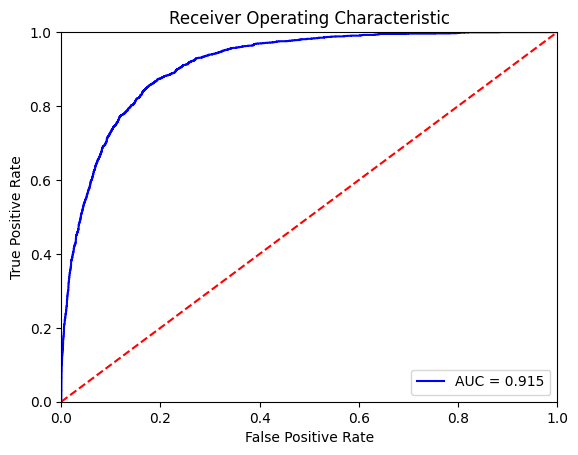

In [8]:
fpr, tpr, threshold = roc_curve(y_test_tensor, pred_win_rate_test)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f"AUC = {roc_auc_score(y_test_tensor, pred_win_rate_test):.3}")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

___
#### Analyze Price-Response Function Parameters

In [9]:
categorical_features_test = pd.concat(
    [
        pd.from_dummies(X_test[[x for x in training_data.columns if "goods_type" in x]], sep="_"),
        pd.from_dummies(X_test[[x for x in training_data.columns if "brand_tier" in x]], sep="_"),
    ],
    axis=1,
).reset_index()

pred_test_params = pd.DataFrame({
    "predicted_win_rate": pred_win_rate_test.ravel(), 
    "max_win_rate_param": pred_max_win_rate_test.ravel(),
    "bias_param": pred_bias_test.ravel(),
    "sensitivity_param": pred_sensitivity_test.ravel(),
})

pred_analysis = pd.concat(
    [
        X_test[["past_spending", "price", "quantity", "membership_flag"]].reset_index(),
        categorical_features_test,
        pred_test_params,
    ], 
    axis=1
).drop(columns="index")

pred_analysis.head()

,past_spending,price,quantity,membership_flag,goods,brand,predicted_win_rate,max_win_rate_param,bias_param,sensitivity_param
0,602.03,114.473495,9,1,type_kichenware,tier_highend,0.346830,0.774844,0.094657,1.013562
1,946.20,435.637162,5,1,type_furniture,tier_popular,0.080906,0.563761,0.930582,4.157219
2,1003.28,74.371555,1,1,type_eletronics,tier_cheap,0.028733,0.411350,1.602815,7.078995
3,202.19,172.194491,9,1,type_kichenware,tier_highend,0.253196,0.734034,0.285041,1.353312
4,1424.06,175.639178,10,0,type_eletronics,tier_cheap,0.308284,0.789692,0.106534,0.866128


type_clothing 0.16437349
type_eletronics 0.11530638
type_food 0.26983842
type_furniture 0.12001672
type_kichenware 0.18073325
type_medicine 0.24385041
tier_cheap 0.2494704
tier_highend 0.122965366
tier_popular 0.17310953
0 0.114044726
1 0.2507813


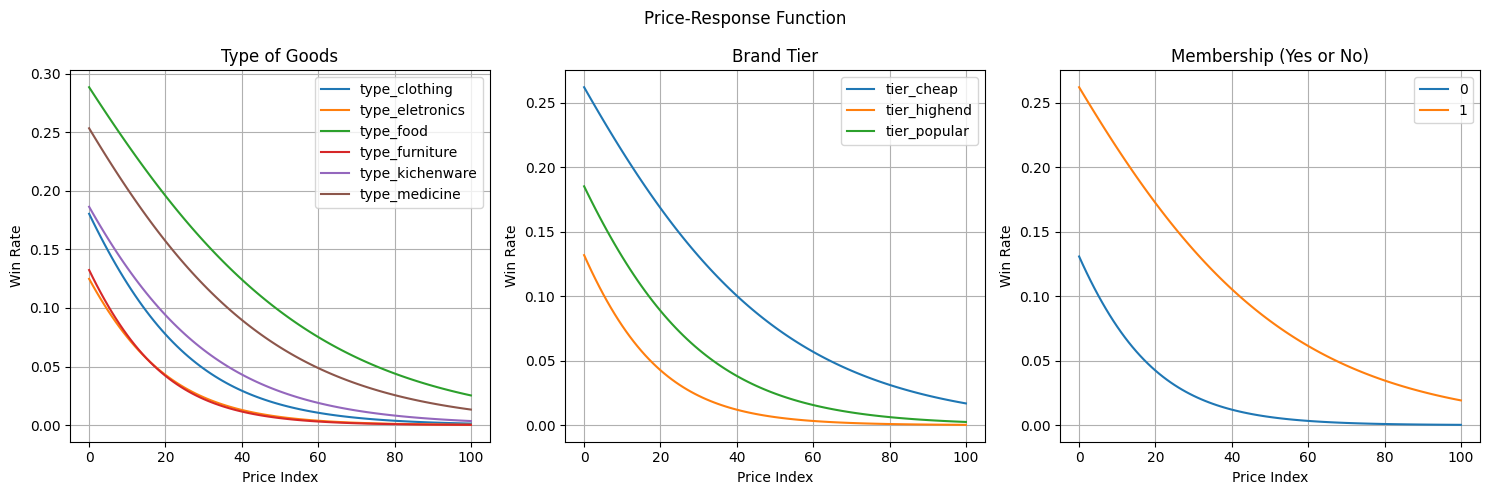

In [10]:
def price_response_function(params, price):
    return params[0] / (1 + np.exp(params[1] + params[2] * price))

def price_response_plot(feature, ax, title):
    avg_params_by_feature = pred_analysis.groupby(feature)[
        ["max_win_rate_param", "bias_param", "sensitivity_param", "predicted_win_rate"]
    ].mean()
    
    for value in avg_params_by_feature.index:
        avg_params = avg_params_by_feature.loc[value].values
        print(value, avg_params[-1])
        prices = np.linspace(0, 1, 101)
        responses = [price_response_function(avg_params[:-1], x) for x in prices]
        ax.plot(responses, label=value)
        ax.set_title(title)
        ax.set_xlabel("Price Index")
        ax.set_ylabel("Win Rate")
    
    ax.legend()
    ax.grid()

fig, ax = plt.subplots(1,3,figsize=(15,5))

price_response_plot("goods", ax[0], "Type of Goods")
price_response_plot("brand", ax[1], "Brand Tier")
price_response_plot("membership_flag", ax[2], "Membership (Yes or No)")

plt.suptitle("Price-Response Function")
plt.tight_layout()

___
#### Price Optimization

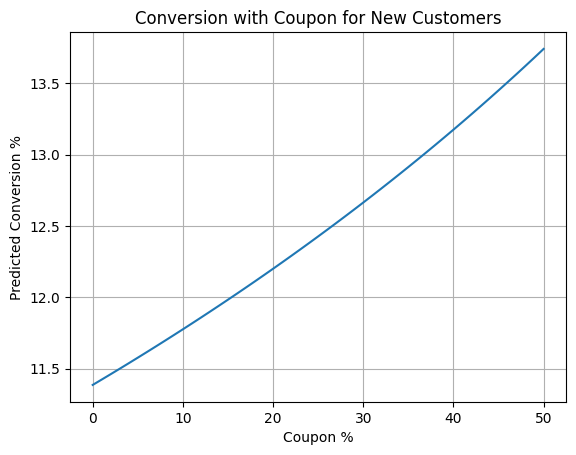

In [11]:
def simulate_price_change(_df, change_rate):
    """Predict win rates with discounted prices"""
    _df["price"] = _df["price_original"] * (1 + change_rate)
    _df["price"] = _df.apply(
        lambda x: price_scalers.get(x["goods"]).transform(np.array(x["price"]).reshape(1,-1)).ravel()[0], 
        axis=1,
    )
    price_tensor = torch.tensor(_df["price"].values.reshape(-1,1), dtype=torch.float32)
    
    features = features_test[features_test.index.isin(_df.index)]
    features_tensor = torch.tensor(features.values, dtype=torch.float32)
    y = y_test[y_test.index.isin(_df.index)]
    y_tensor = torch.tensor(y.values.reshape(-1,1), dtype=torch.float32)
    
    win_rate_test, _, _, _ = model(features_tensor, price_tensor)
    return win_rate_test.detach().numpy()


new_customers = price_product_info[
    (training_data["membership_flag"]==0) 
    & (price_product_info.index.isin(X_test.index))
]
new_customers["price_original"] = new_customers["price"]

avg_win_rates = []
for x in np.arange(0, -0.51, -0.01):
    avg_win_rates.append(simulate_price_change(new_customers, x).mean())

plt.plot([x * 100 for x in avg_win_rates])
plt.title("Conversion with Coupon for New Customers")
plt.xlabel("Coupon %")
plt.ylabel("Predicted Conversion %")
plt.grid()

-0.9 9.16487291342212 0.004984069909029973 0.30301124
-0.8 18.32974582684424 0.019574185658961858 0.29903904
-0.7 27.49461874026636 0.03416430140889374 0.29524735
-0.6 36.65949165368848 0.04875441715882562 0.2916238
-0.5 45.8243645671106 0.0633445329087575 0.28815654
-0.4 54.98923748053272 0.07793464865868938 0.28483438
-0.3 64.15411039395484 0.09252476440862126 0.2816471
-0.2 73.31898330737695 0.10711488015855314 0.2785852
-0.1 82.48385622079907 0.12170499590848503 0.27564
-0.0 91.6487291342212 0.1362951116584169 0.27280375
0.1 100.8136020476433 0.15088522740834878 0.27006924
0.2 109.97847496106544 0.16547534315828064 0.26742998
0.3 119.14334787448757 0.18006545890821254 0.26488006
0.4 128.3082207879097 0.19465557465814448 0.26241407
0.5 137.4730937013318 0.20924569040807628 0.26002708
0.6 146.6379666147539 0.22383580615800822 0.2577145
0.7 155.80283952817607 0.23842592190794012 0.25547227
0.8 164.9677124415982 0.253016037657872 0.25329652


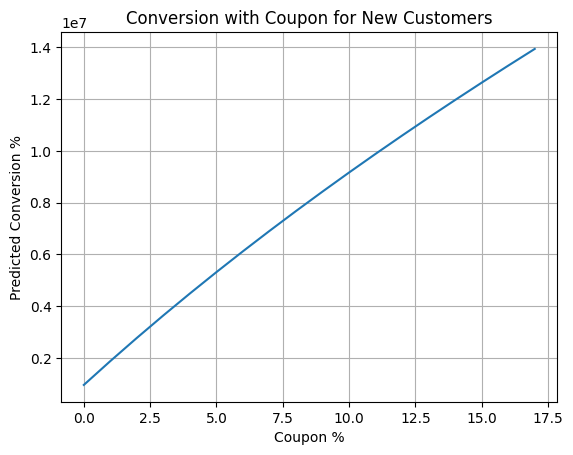

In [12]:
brand_tiers = price_product_info[(price_product_info["brand"]=="tier_cheap") & (price_product_info.index.isin(X_test.index))]
brand_tiers["price_original"] = brand_tiers["price"]

x = simulate_price_change(brand_tiers, 0.1)

expected_revenues = []
for x in np.arange(-0.9, 0.9, 0.1):
    new_prices = brand_tiers["price_original"].values * (1 + x)
    new_win_rates = simulate_price_change(brand_tiers, x).ravel()
    expected_revenues.append((new_prices * new_win_rates).sum())
    print(np.round(x, 1), new_prices.mean(), brand_tiers["price"].mean(), new_win_rates.mean())

plt.plot([x * 100 for x in expected_revenues])
plt.title("Conversion with Coupon for New Customers")
plt.xlabel("Coupon %")
plt.ylabel("Predicted Conversion %")
plt.grid()